# Meta explainer network for Tox21 dataset  

In [34]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from tqdm import tqdm
import os
import shap
import pickle
import numpy as np
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel, AutoConfig
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader


## Extracting more features from our SMILES columns

In [4]:
# ✅ Load the original dataset
df = pd.read_csv("Data_v2/original/tox21.csv")  # adjust path if needed

# 📌 Chemical descriptors to extract
def extract_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * 9  # Same number of descriptors
    return [
        Descriptors.MolWt(mol),                       # Molecular Weight
        Descriptors.MolLogP(mol),                     # LogP
        Descriptors.TPSA(mol),                        # Topological Polar Surface Area
        Descriptors.NumHDonors(mol),                  # Hydrogen bond donors
        Descriptors.NumHAcceptors(mol),               # Hydrogen bond acceptors
        Descriptors.NumRotatableBonds(mol),           # Rotatable bonds
        rdMolDescriptors.CalcNumRings(mol),           # Total ring count
        rdMolDescriptors.CalcNumAromaticRings(mol),   # Aromatic ring count
        Chem.rdMolDescriptors.CalcExactMolWt(mol)     # Exact molecular weight
    ]

# 🧪 Apply descriptor extraction
descriptor_names = [
    'MolWt', 'LogP', 'TPSA', 'HDonors', 'HAcceptors',
    'RotBonds', 'RingCount', 'AromaticRings', 'ExactMolWt'
]

# Add progress bar
tqdm.pandas()
descriptor_df = df['smiles'].progress_apply(lambda x: pd.Series(extract_descriptors(x), index=descriptor_names))

# 🧬 Merge descriptors into the original dataset
df_enriched = pd.concat([df, descriptor_df], axis=1)

# 💾 Save enriched dataset to your chosen directory
save_path = "Data_v2/processed/tox21_new.csv"  # change this
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_enriched.to_csv(save_path, index=False)

print(f"✅ Enriched dataset saved to: {save_path}")

100%|██████████| 7831/7831 [00:04<00:00, 1783.85it/s]

✅ Enriched dataset saved to: Data_v2/processed/tox21_new.csv


## EDA

need to understand the new created dataset better to ensure if it's ready for model training or it needs more pre-processing. this is done via:

* Class balance: how many molecules are toxic per target
* Correlation between descriptors and toxic labels
* Descriptor distributions per toxicity label
* Potential bias in data that might affect interpretability

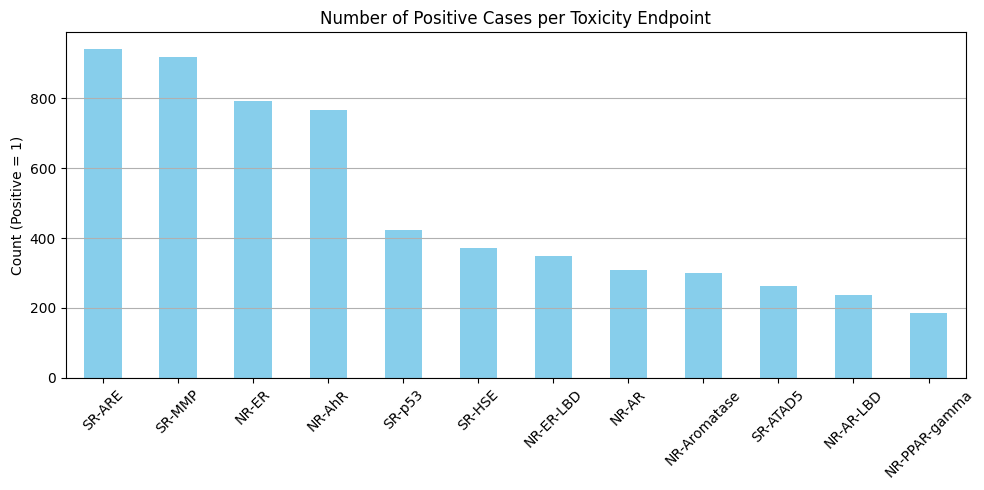

In [5]:
## Class Distribution 
import matplotlib.pyplot as plt

tox_labels = [
    col for col in df_enriched.columns if col.startswith("NR-") or col.startswith("SR-")
]

# Count positive labels for each toxicity endpoint
label_counts = df_enriched[tox_labels].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
label_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Positive Cases per Toxicity Endpoint")
plt.ylabel("Count (Positive = 1)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


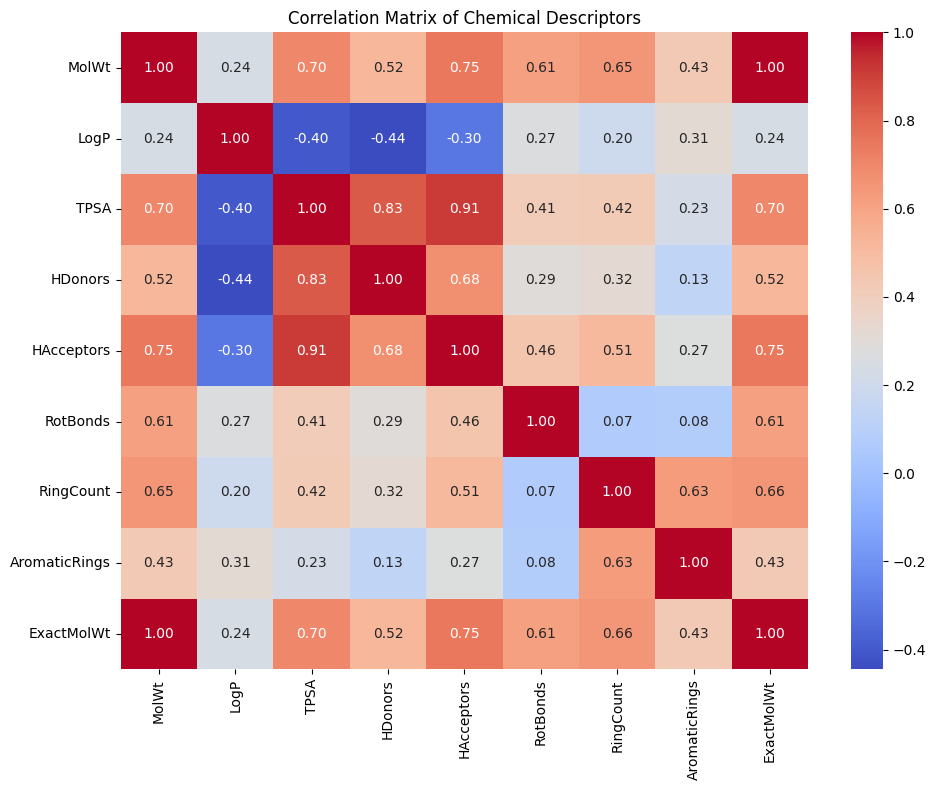

In [6]:
## Correlation between Descriptors 
import seaborn as sns

desc_cols = ['MolWt', 'LogP', 'TPSA', 'HDonors', 'HAcceptors',
             'RotBonds', 'RingCount', 'AromaticRings', 'ExactMolWt']

plt.figure(figsize=(10, 8))
sns.heatmap(df_enriched[desc_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Chemical Descriptors")
plt.tight_layout()
plt.show()


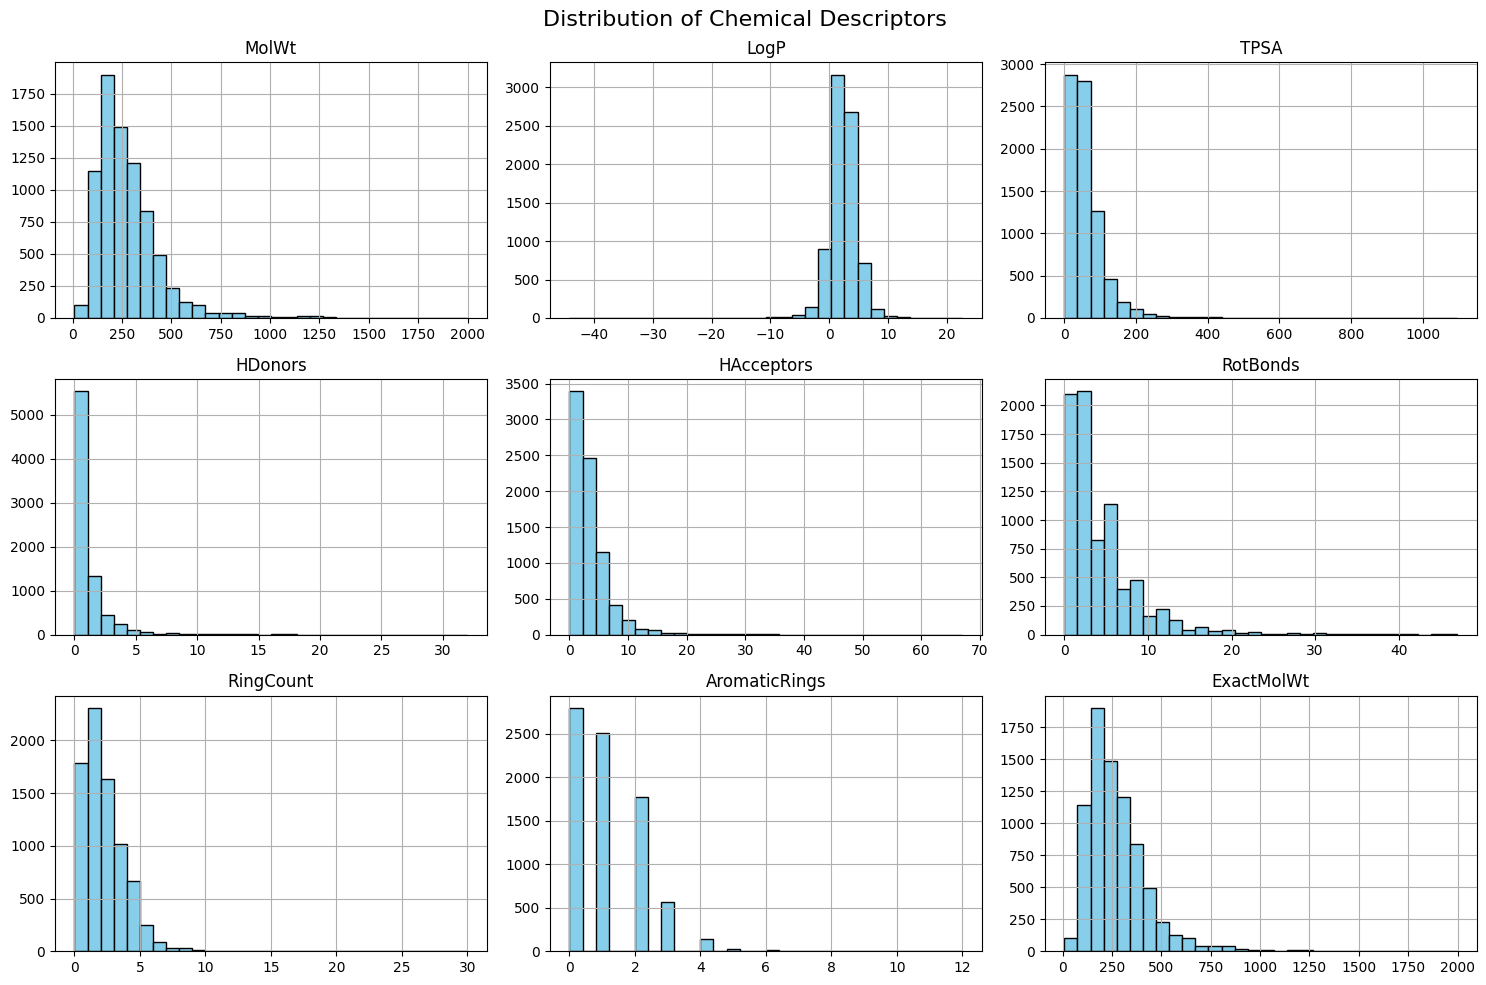

In [7]:
## Descriptor Distribution (Hist)
df_enriched[desc_cols].hist(bins=30, figsize=(15, 10), color="skyblue", edgecolor="black")
plt.suptitle("Distribution of Chemical Descriptors", fontsize=16)
plt.tight_layout()
plt.show()

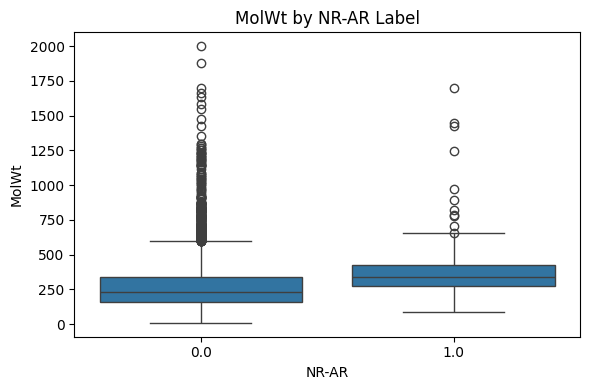

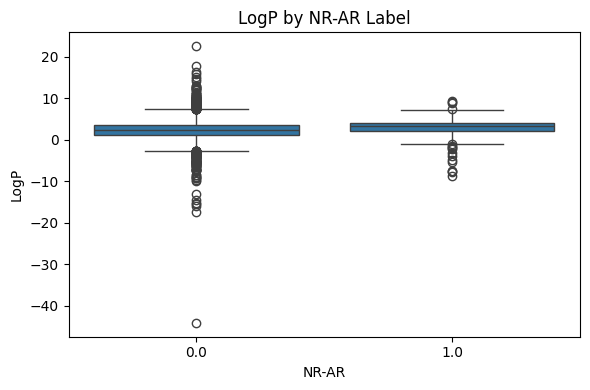

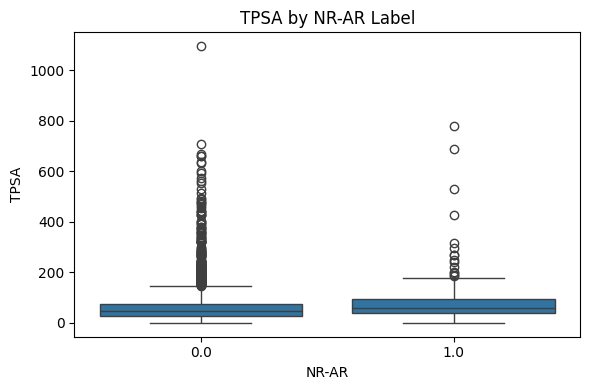

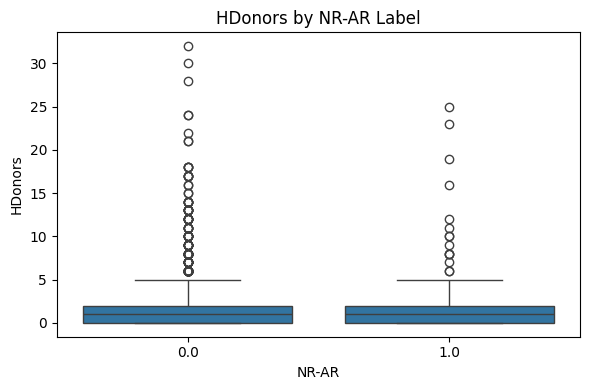

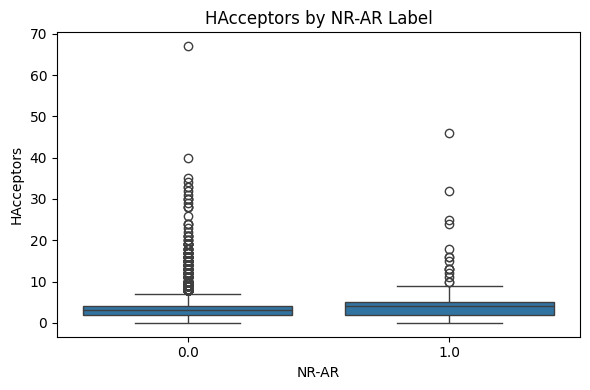

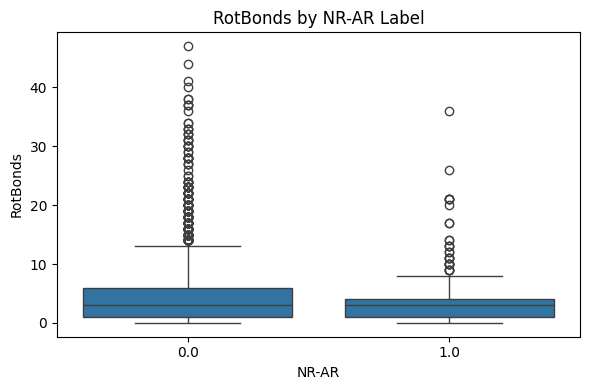

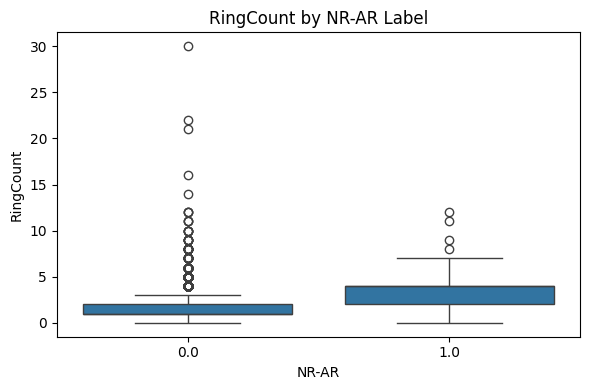

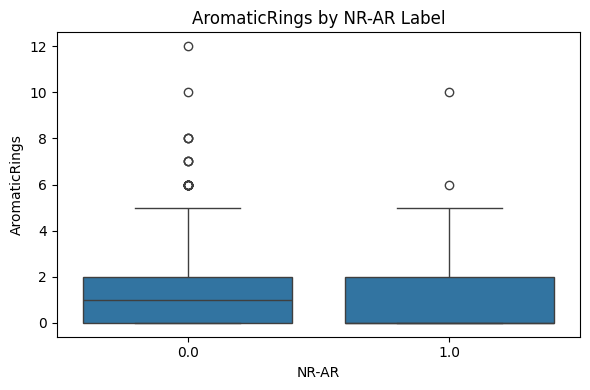

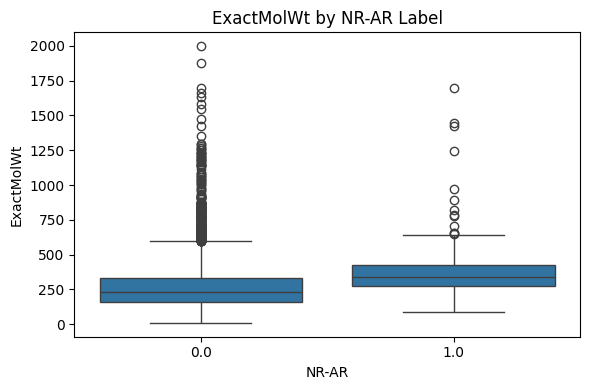

In [8]:
## Descriptor vs class (Box-plots)
for col in desc_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='NR-AR', y=col, data=df_enriched)
    plt.title(f"{col} by NR-AR Label")
    plt.tight_layout()
    plt.show()


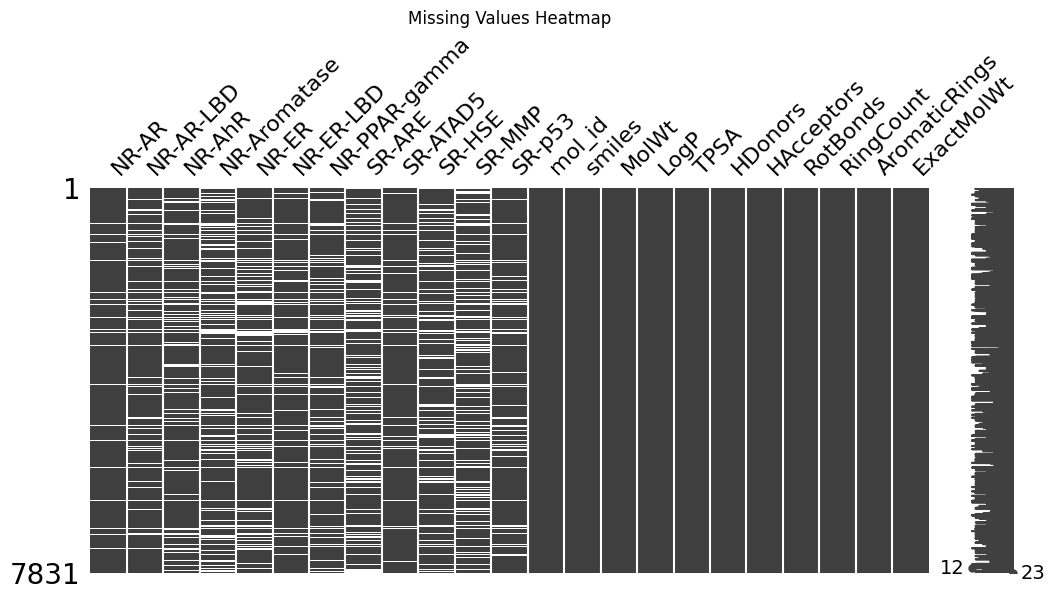

In [9]:
## Missing value Heatmap
import missingno as msno

msno.matrix(df_enriched, figsize=(12, 5))
plt.title("Missing Values Heatmap")
plt.show()


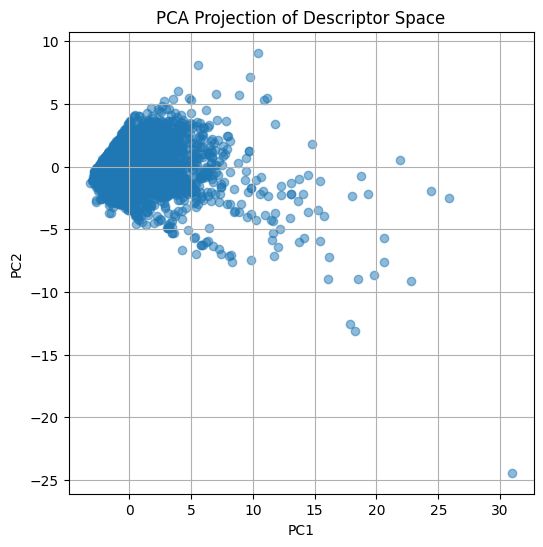

In [ ]:
#PCA/UMAP for 2DD Visualisation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_enriched[desc_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Projection of Descriptor Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## Model pipeline plan will be using ChemBERTa again

so we have discovered that we do have class imbalances so we are going approach this via the following:

* Preprocessing: 
    * Handle missing values.
    * Extract features and labels.
    * Compute class weights.

* Model Training (XGBoost):
    * Train one model per label (e.g., NR-AR, SR-MMP etc).
    * use **scale-pos-weight** for imbalance.

* saving:
    * saving models and metadata for later use.

* SHAP: 
    * need to store X_train for SHAP explanations later.

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: NVIDIA GeForce RTX 4070 Ti


### Load, preprocess and Tokenize

In [3]:
# Load and prepare data
df = pd.read_csv("Data_v2/processed/tox21_new.csv")
label_cols = [col for col in df.columns if col.startswith("NR-") or col.startswith("SR-")]
df = df.dropna(subset=["smiles"] + label_cols).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(df["smiles"], df[label_cols], test_size=0.2, random_state=42)

from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class SMILESDataset(Dataset):
    def __init__(self, smiles, labels):
        self.data = pd.DataFrame({'smiles': smiles})
        self.labels = labels.reset_index(drop=True)
        self.label_cols = labels.columns.tolist()

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.data.iloc[idx]['smiles'],
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        inputs = {k: v.squeeze(0) for k, v in encoding.items()}
        inputs['labels'] = torch.tensor(self.labels.iloc[idx].values.astype(np.float32))
        return inputs

train_loader = DataLoader(SMILESDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(SMILESDataset(X_val, y_val), batch_size=32)

### Model definition + train model

In [4]:
from transformers import AutoModel
import torch.nn as nn
import numpy as np

class ChemBERTaClassifier(nn.Module):
    def __init__(self, n_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.bert.config.hidden_size, n_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(outputs.last_hidden_state[:, 0])

def multilabel_accuracy(preds, labels, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    correct = (preds == labels).float().mean()
    return correct

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChemBERTaClassifier(n_labels=len(label_cols)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for batch in train_loader:
        ids, mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, labels)
        acc = multilabel_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Validation loop
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            ids, mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            acc = multilabel_accuracy(outputs, labels)
            val_loss += loss.item()
            val_acc += acc.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")


Epoch 1 | Train Loss: 0.1953, Acc: 0.9432 | Val Loss: 0.1086, Acc: 0.9732
Epoch 2 | Train Loss: 0.1170, Acc: 0.9708 | Val Loss: 0.1038, Acc: 0.9732
Epoch 3 | Train Loss: 0.1104, Acc: 0.9707 | Val Loss: 0.1010, Acc: 0.9741
Epoch 4 | Train Loss: 0.1065, Acc: 0.9718 | Val Loss: 0.0977, Acc: 0.9745
Epoch 5 | Train Loss: 0.1009, Acc: 0.9720 | Val Loss: 0.1012, Acc: 0.9736
Epoch 6 | Train Loss: 0.0961, Acc: 0.9734 | Val Loss: 0.0975, Acc: 0.9741
Epoch 7 | Train Loss: 0.0901, Acc: 0.9740 | Val Loss: 0.1013, Acc: 0.9733
Epoch 8 | Train Loss: 0.0845, Acc: 0.9760 | Val Loss: 0.0999, Acc: 0.9741
Epoch 9 | Train Loss: 0.0790, Acc: 0.9768 | Val Loss: 0.0990, Acc: 0.9738
Epoch 10 | Train Loss: 0.0740, Acc: 0.9782 | Val Loss: 0.0981, Acc: 0.9749
Epoch 11 | Train Loss: 0.0686, Acc: 0.9800 | Val Loss: 0.1014, Acc: 0.9746
Epoch 12 | Train Loss: 0.0619, Acc: 0.9811 | Val Loss: 0.1018, Acc: 0.9732
Epoch 13 | Train Loss: 0.0574, Acc: 0.9823 | Val Loss: 0.1053, Acc: 0.9738
Epoch 14 | Train Loss: 0.0512, Acc

In [6]:
import joblib

save_dir = "models/chemberta_tox21"
os.makedirs(save_dir, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), os.path.join(save_dir, "model.pt"))

# Save tokenizer
tokenizer.save_pretrained(save_dir)

# Save label column order for inference
joblib.dump(label_cols, os.path.join(save_dir, "labels.pkl"))

print("✅ Model, tokenizer, and label metadata saved.")


✅ Model, tokenizer, and label metadata saved.


### Model Eval

In [7]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_preds.append(probs)
        all_labels.append(labels)

# Combine all batches
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Binarise predictions with threshold
threshold = 0.5
binary_preds = (all_preds > threshold).astype(int)

# Per-label metrics
for i, label in enumerate(label_cols):
    try:
        auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        print(f"\n🔬 {label}: AUC = {auc:.3f}")
        print(classification_report(all_labels[:, i], binary_preds[:, i], zero_division=0))
        print("Confusion Matrix:")
        print(confusion_matrix(all_labels[:, i], binary_preds[:, i]))
    except ValueError:
        print(f"\n⚠️ {label}: Not enough class variance for metrics")



🔬 NR-AR: AUC = 0.725
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       603
         1.0       0.71      0.38      0.50        13

    accuracy                           0.98       616
   macro avg       0.85      0.69      0.75       616
weighted avg       0.98      0.98      0.98       616

Confusion Matrix:
[[601   2]
 [  8   5]]

🔬 NR-AR-LBD: AUC = 0.762
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       609
         1.0       0.50      0.43      0.46         7

    accuracy                           0.99       616
   macro avg       0.75      0.71      0.73       616
weighted avg       0.99      0.99      0.99       616

Confusion Matrix:
[[606   3]
 [  4   3]]

🔬 NR-AhR: AUC = 0.773
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       585
         1.0       0.42      0.16      0.23        31

    accuracy                 

## SHAP

Use shap.GradientExplainer (since we’re using a PyTorch model on GPU)

Explain a few samples from your validation set

Visualise token-level contributions from SMILES

Save SHAP values for later use in the meta-explainer

In [22]:
import shap
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn

# ✅ Classifier definition
class ChemBERTaClassifier(nn.Module):
    def __init__(self, n_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.bert.config.hidden_size, n_labels)
        )

    def forward(self, input_ids, attention_mask, return_embedding=False):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        if return_embedding:
            return pooled
        return self.classifier(pooled)

# ✅ Wrapper model for class-specific SHAP
class WrappedSingleClassModel(nn.Module):
    def __init__(self, classifier_head, class_index):
        super().__init__()
        self.classifier = classifier_head
        self.class_index = class_index

    def forward(self, x):
        return self.classifier(x)[:, self.class_index]

# ✅ Load model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChemBERTaClassifier(n_labels=len(label_cols))
model.load_state_dict(torch.load("models/chemberta_tox21/model.pt", map_location=device))
model.to(device).eval()
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# ✅ Select 8 molecules
texts = X_val.iloc[:8].tolist()
labels = y_val.iloc[:8].values

encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

# ✅ Get embeddings
with torch.no_grad():
    input_embeddings = model.bert.embeddings(input_ids)

# ✅ Save directory
shap_dir = "Data_v2/ChemBERTa_SHAP"
os.makedirs(shap_dir, exist_ok=True)

# ✅ Loop over classes
for class_idx in range(len(label_cols)):
    print(f"🔍 Explaining class {class_idx}: {label_cols[class_idx]}")
    
    # Proper PyTorch module
    wrapped = WrappedSingleClassModel(model.classifier, class_idx).to(device)
    wrapped.eval()

    explainer = shap.DeepExplainer(wrapped, input_embeddings)
    shap_vals = explainer.shap_values(input_embeddings)

    np.save(os.path.join(shap_dir, f"shap_token_values_class{class_idx}.npy"), shap_vals)
    print(f"✅ Saved class {class_idx} SHAP")

# Save input context
np.save(os.path.join(shap_dir, "input_ids.npy"), input_ids.cpu().numpy())
np.save(os.path.join(shap_dir, "labels.npy"), labels)
print("✅ Input IDs and true labels saved.")


🔍 Explaining class 0: NR-AR
✅ Saved class 0 SHAP
🔍 Explaining class 1: NR-AR-LBD
✅ Saved class 1 SHAP
🔍 Explaining class 2: NR-AhR
✅ Saved class 2 SHAP
🔍 Explaining class 3: NR-Aromatase
✅ Saved class 3 SHAP
🔍 Explaining class 4: NR-ER
✅ Saved class 4 SHAP
🔍 Explaining class 5: NR-ER-LBD
✅ Saved class 5 SHAP
🔍 Explaining class 6: NR-PPAR-gamma
✅ Saved class 6 SHAP
🔍 Explaining class 7: SR-ARE
✅ Saved class 7 SHAP
🔍 Explaining class 8: SR-ATAD5
✅ Saved class 8 SHAP
🔍 Explaining class 9: SR-HSE
✅ Saved class 9 SHAP
🔍 Explaining class 10: SR-MMP
✅ Saved class 10 SHAP
🔍 Explaining class 11: SR-p53
✅ Saved class 11 SHAP
✅ Input IDs and true labels saved.


## Meta Explainer

### 1: Data & model loading 

NameError: name 'ChemBERTaClassifier' is not defined